# Bayesian AB Testing
Based on the click rate, open rate, click through rate, or response rate with the original version prior to any testing and the sample size used, you can come up with a distribution. Yes, this is just one number (the rate) and another number (the sample size). The larger the sample size, the tighter the distribution. Then you compare that to the distribution and sample of the new one using math and stuff. I think it gets more complicated eventually. As the sample size increases, the bayesian approach becomes more similar to the frequentist approach. When working with binary target, we can use a Bernoulli distribution.

# Table of Contents
- [TDS Bayesian AB Testing with Python - Easy Guide](#one)

***
***
***

# TDS Bayesian AB Testing with Python - Easy Guide <a id="one"></a>
https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a

In [9]:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [11]:
from scipy.stats import beta
import numpy as np
# from calc_prob import calc_prob_between

In [12]:
#This is the known data: imporessions and conversions for the Control and Test set
imps_ctrl,convs_ctrl=16500, 30 
imps_test, convs_test=17000, 50

In [13]:
#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

In [14]:
#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

In [15]:
#calculating the probability for Test to be better than Control
prob=calc_prob_between(beta_T, beta_C)

In [16]:
print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")
#output: Test option lift Conversion Rates by 59.68% with 98.2% probability.

Test option lift Conversion Rates by 59.68% with 98.2% probability.


In [17]:
import matplotlib.pyplot as plt

def calc_beta_mode(a, b):
    '''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)

def plot(betas, names, linf=0, lsup=0.01):
    '''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 100)
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # the variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample, conversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.yticks([])
    plt.legend()
    plt.show()

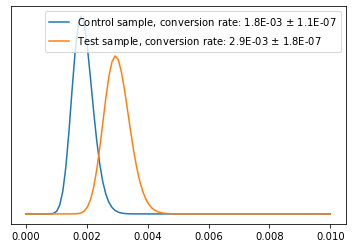

In [18]:
plot([beta_C, beta_T], names=["Control", "Test"])

In [19]:
from mpmath import betainc

In [20]:
p=betainc(a_T, b_T, 0.003,1, regularized=True) #result: 0.48112566853812544

In [27]:
import seaborn as sns
import pandas as pd
import numpy as np
imps_ctrl,convs_ctrl=16500, 30 
imps_test, convs_test=17000, 50

In [22]:
#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

In [23]:
val_C=np.random.beta(a_C, b_C, 1000000)
val_T=np.random.beta(a_T, b_T, 1000000)
vals=np.vstack([val_C, val_T]).T

In [24]:
limit=0.004

In [25]:
df=pd.DataFrame(vals, columns=['Control', 'Test'])
df=df[df['Control']<limit]
df=df[df['Test']<limit]

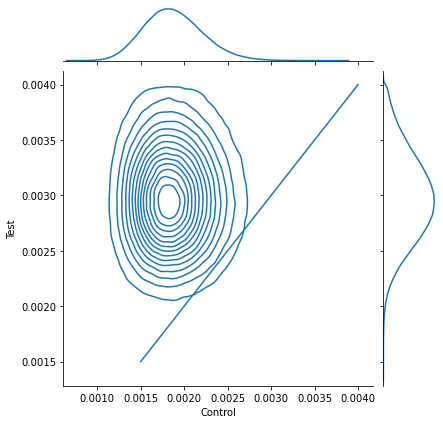

In [26]:
g=sns.jointplot(x=df.Control, y=df.Test, kind='kde', n_levels=15)
g.ax_joint.plot([0.0015, limit], [0.0015, limit])

***
***
***